In [6]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib
import sys

import radvel
sys.path.append('./')
sys.path.append('../')

from sim.hires import exposure
from sim.starlist import counts_to_err
from sim import mock_up_rvs

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['font.size'] = 18
simulated_planets = '../data/barclay+CTL.csv'

In [7]:
kexp = 250  # maximum exp counts
nobs = 60  # number of observations per target

# Read in Barclay + CTL merged catalogue

In [8]:
sp = pd.read_csv(simulated_planets, comment="#")

units = dict(sp.iloc[0])
sp = sp.iloc[2:]

for col in sp.columns:
    try:
        sp[col] = sp[col].values.astype(float)
    except ValueError:
        continue
        
# sp = sp.merge(ctl, on='TICID', how='left', suffixes=['', '_tic'])
isp = sp.copy()
print(sp.columns)


Index(['_RAJ2000', '_DEJ2000', 'TICID', 'RAJ2000', 'DEJ2000', 'Obslen', 'Vmag',
       'Kmag', 'Jmag', 'Tmag',
       ...
       'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition',
       'duplicate_i', 'priority', 'objID'],
      dtype='object', length=118)


# Perform some calculations with the columns

In [9]:
sp = isp.copy()

multis = sp.groupby('TICID').count().sort_values(by='Vmag', ascending=False).query('Vmag > 1').reset_index()
multis['Npl'] = multis['Vmag']
multis = multis[['TICID', 'Npl']]
sp = pd.merge(sp, multis, on='TICID', how='left')

sp['Rs'] = sp['R*'].values
sp['Mp'] = mock_up_rvs.calc_mp(sp['Rp'].values)
sp['Kp'] = radvel.utils.semi_amplitude(sp['Mp'].values, 
                                       sp['Perp'].values, 
                                       sp['R*'].values,   # R* for M*
                                       sp['Ecc'].values,
                                       Msini_units='earth')
sp['a'] = (sp['mass'] * (sp['Perp'] / 365.) ** 2.) ** (1. / 3.)
sp['sinc'] = (sp['Teff'] / 5778.) ** 4.0 * (sp['R*'] / sp['a']) ** 2.0


exp = np.clip(exposure.exposure_time(sp['Vmag'].values, kexp, iod=True), 0, 2700) 

kexp_list = [exposure.exposure_counts(v, e, iod=True) for v, e in zip(sp['Vmag'].values, exp)]

# for v, e in zip(sp['Vmag'].values, exp):
#     print(v, e, exposure.exposure_counts(v, e, iod=True))
sp['kexp'] = kexp_list

sp['exptime'] =  exp * nobs  
sp['exptime'] += exposure.exposure_time(sp['Vmag'].values, 3*kexp, iod=False)  # template 3*normal obs

sp['jitter'] = np.sqrt(counts_to_err(sp['kexp'].values)**2 + \
                       np.random.uniform(1.0, 4.0, size=len(sp))**2)  # random jitter from 1.0 to 7.0 m/s jitter
sp['Ksig'] = (sp['Kp'] * np.sqrt(nobs)) / sp['jitter']
sp['Kerr'] = sp['jitter'] / np.sqrt(nobs)

sp = sp.sort_values(by='Vmag').reset_index()

# Filter

In [10]:
filters = """_DEJ2000 > 0
Teff < 6100
Vmag < 13.5
Kp > 2.0
Rs < 1.5
Rp < 12
Ksig > 4.0"""

for filt in filters.split('\n'):
    print(filt)
    sp = sp.query(filt)

spf = sp.iloc[:50]  # n brightest
close = sp.sort_values(by='Dist').iloc[:50]
spf = pd.concat([spf, close])  # +n closest
# spf = pd.concat([spf, sp.sort_values(by='Rp').iloc[:27]])  # +n smallest
multi = sp.query('Npl > 1')
usp = sp.query('Perp < 1.5')
spf = pd.concat([spf, multi])
spf = pd.concat([spf, usp])
spf = spf.drop_duplicates()


num_nights = (spf.exptime.sum() / (10*3600))
num_targets = spf.TICID.count()
print(spf.TICID.count(), (spf.exptime.sum() / (10*3600)), spf.Ksig.min())


_DEJ2000 > 0
Teff < 6100
Vmag < 13.5
Kp > 2.0
Rs < 1.5
Rp < 12
Ksig > 4.0
141 474.12150403949016 4.026213891016045


# Histogram plots

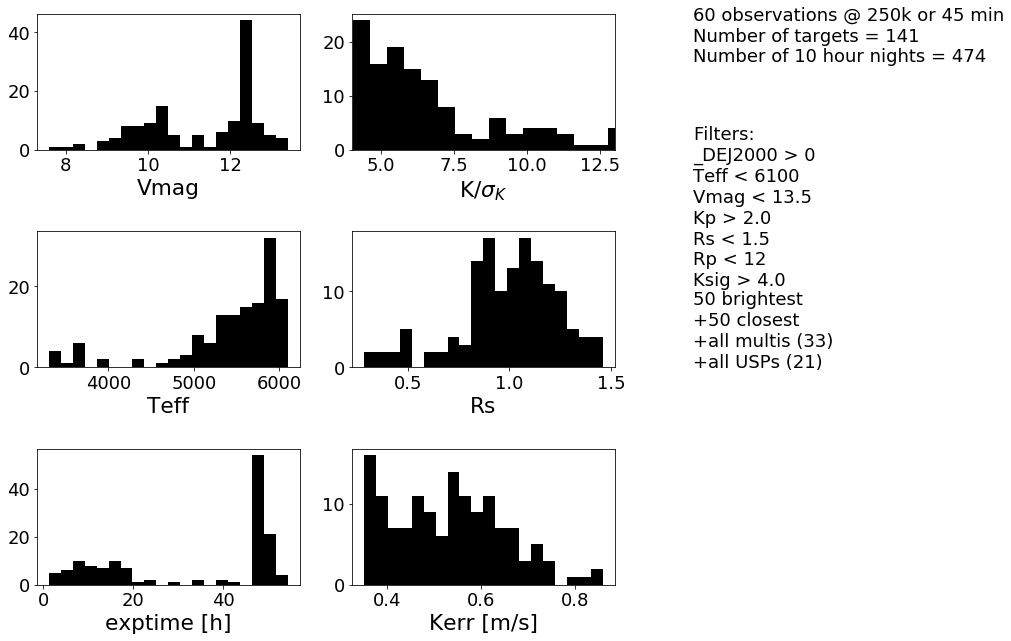

In [11]:
bins = 20

fig = pl.figure(figsize=(16,10.5))
pl.subplots_adjust(hspace=0.6)

pl.subplot(3,3,1)
pl.hist(spf['Vmag'], bins=bins)
pl.xlabel('Vmag')

pl.subplot(3,3,2)
pl.hist(spf['Ksig'], bins=bins*2)
pl.xlabel('K/$\sigma_K$')
pl.xlim(4, 13)

pl.subplot(3,3,5)
pl.hist(spf['Rs'], bins=bins)
pl.xlabel('Rs')

pl.subplot(3,3,4)
pl.hist(spf['Teff'], bins=bins)
pl.xlabel('Teff')

pl.subplot(3,3,7)
pl.hist(spf['exptime']/3600, bins=bins)
pl.xlabel('exptime [h]')

pl.subplot(3,3,8)
pl.hist(spf['Kerr'], bins=bins)
pl.xlabel('Kerr [m/s]')


ax = pl.subplot(3,3,3)
ax.axis('off')

pl.annotate('{} observations @ {}k or 45 min'.format(nobs, kexp), xy=(0.1, 0.95))
pl.annotate('Number of targets = {}'.format(num_targets), xy=(0.1, 0.8))
pl.annotate('Number of 10 hour nights = {:.0f}'.format(num_nights), xy=(0.1, 0.65))

ax = pl.subplot(3,3,6)
ax.axis('off')

pl.annotate('Filters:\n{}'.format(filters), xy=(0.1, 0.6))
pl.annotate('50 brightest\n+{} closest\n+all multis ({})\n+all USPs ({})'.format(len(close), 
                                                                                 len(multi), 
                                                                                 len(usp)), 
            xy=(0.1, 0.0))

pl.savefig('fig_target-dist.pdf')

# Scatter plots

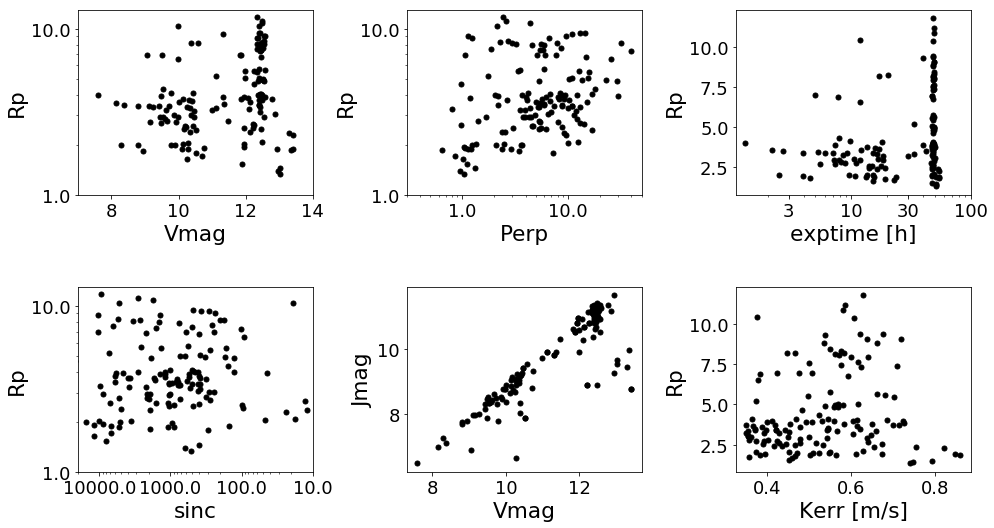

In [12]:
fig = pl.figure(figsize=(16,8.5))
pl.subplots_adjust(hspace=0.5, wspace=0.4)

pl.subplot(2,3,1)
x = 'Vmag'
y = 'Rp'
pl.semilogy(spf[x], spf[y], 'ko')
yt = pl.yticks()[0]
pl.yticks(yt, yt)
pl.xlabel('{}'.format(x))
pl.ylabel('{}'.format(y))
pl.ylim(1, 13)
pl.xlim(7, 14)


ax = pl.subplot(2,3,2)
x = 'Perp'
y = 'Rp'
ax.loglog(spf[x], spf[y], 'ko')
xt = pl.xticks()[0]
pl.xticks(xt, xt)
yt = pl.yticks()[0]
pl.yticks(yt, yt)
pl.xlabel('{}'.format(x))
pl.ylabel('{}'.format(y))
pl.xlim(0.3, 50)
pl.ylim(1, 13)

ax = pl.subplot(2,3,4)
x = 'sinc'
y = 'Rp'
ax.loglog(spf[x], spf[y], 'ko')
xt = pl.xticks()[0]
pl.xticks(xt, xt)
yt = pl.yticks()[0]
pl.yticks(yt, yt)
pl.xlabel('{}'.format(x))
pl.ylabel('{}'.format(y))
pl.xlim(2e4, 10)
pl.ylim(1, 13)



ax = pl.subplot(2,3,5)
x = 'Vmag'
y = 'Jmag'
ax.plot(spf[x], spf[y], 'ko')
pl.xlabel('{}'.format(x))
pl.ylabel('{}'.format(y))
# pl.xlim(-0.5, 0.5)
# pl.ylim(1, 1.7)


ax = pl.subplot(2,3,3)
x = 'exptime'
y = 'Rp'
ax.semilogx(spf[x]/3600, spf[y], 'ko')
pl.xlabel('{} [h]'.format(x))
pl.ylabel('{}'.format(y))
pl.xticks([3, 10, 30, 100], [3, 10, 30, 100])
# pl.xlim(-0.5, 0.5)
# pl.ylim(1, 1.7)


ax = pl.subplot(2,3,6)
x = 'Kerr'
y = 'Rp'
ax.plot(spf[x], spf[y], 'ko')
pl.xlabel('{} [m/s]'.format(x))
pl.ylabel('{}'.format(y))
# pl.xticks([3, 10, 30, 100], [3, 10, 30, 100])
# pl.xlim(-0.5, 0.5)
# pl.ylim(1, 1.7)

pl.savefig('fig_target-scatter.pdf')

# H-R Diagram plot

(0.001, 3)

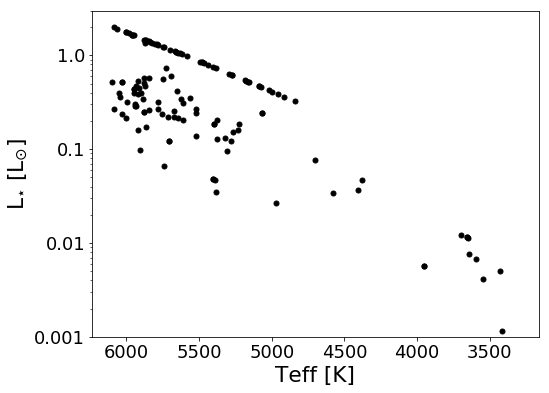

In [13]:
pl.semilogy(spf['Teff'], spf['lum'], 'ko')
pl.xlabel('Teff [K]')
pl.ylabel('L$_{\star}$ [L$_{\odot}$]')

xl = pl.xlim()
pl.xlim(xl[::-1])

yt = pl.yticks()[0]
pl.yticks(yt, yt)
pl.ylim(0.001, 3)

# Save target list

In [14]:
spf.to_csv('target_list.csv', index=False)

# TODO list

In [15]:
"""
overheads
more agressive jitter cut
add jitter tests into time allocation
shallow survey
HR diagram figure
M dwarfs, can cut on planet properties
code on repo
ramp up from 10.5 to 60k (fainter than 12)
"""

'\noverheads\nmore agressive jitter cut\nadd jitter tests into time allocation\nshallow survey\nHR diagram figure\nM dwarfs, can cut on planet properties\ncode on repo\nramp up from 10.5 to 60k (fainter than 12)\n'

In [16]:
sys.path.append('../')
from sim import utils

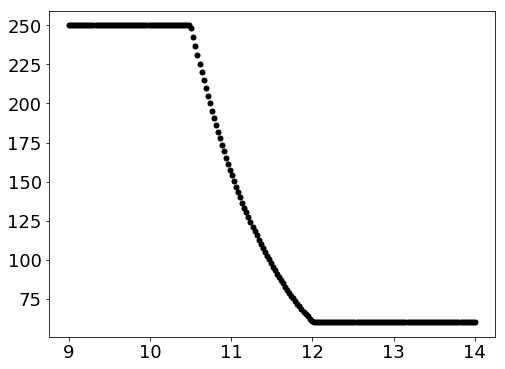

In [17]:
for v in np.linspace(9, 14, 200):
    pl.plot(v, utils.exp_ramp(v), 'ko')
